<a href="https://colab.research.google.com/github/fmejias/CS534-ArtificialIntelligenceProject/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 534 - Artificial Intelligence**

## **Project Title: Predicting Student Intention to Dropout Through Tweets.**

### **Students**


*   Merzia Adamjee
*   Alketa Guxha
*   Felipe Mejias
*   Nikita Boguslavskii




# **Project Configuration**

## **Initial configuration of the environment for the development of the project**

In [1]:
from google.colab import drive
from google.colab import files
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## **Install Textblob and Imbalanced Learn**

In [ ]:
!pip install textblob
!pip install imbalanced-learn
!pip3 install flair

## **Install NLTK datasets and libraries**

In [3]:
import nltk
nltk.download('punkt')
nltk.download('movie_reviews')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

## **Google Authentication to read CSV File from Google Drive**

In [4]:
# Needed for Google Authentication Step
drive.mount('/content/drive')

Mounted at /content/drive


## **Upload Dataset from Google Drive**

In [5]:
DATASET1_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part1_labeled.csv"
DATASET2_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part2_labeled.csv"
DATASET3_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part3_labeled-DONE.csv"
DATASET4_PATH = "/content/drive/My Drive/AI_Project_CS_534/Datasets/dropping_out_tweets_part4_labeled- DONE.csv"

# Read dataset 1
dataset1_df = pd.read_csv(DATASET1_PATH, sep=";")

# Read and Preprocess dataset 2
dataset2_df = (pd.read_csv(DATASET2_PATH)).rename(columns={" tweet": "tweet", " label": "label"})
dataset2_df['label'] = dataset2_df['label'].str.replace(' Intention of dropout', 'Intention of dropout')
dataset2_df['label'] = dataset2_df['label'].str.replace(' Not intention of dropout', 'Not intention of dropout')

# Read dataset 3
dataset3_df = pd.read_csv(DATASET3_PATH, sep=";")
#dataset3_df = dataset3_df[['id', 'tweet', 'label']]
dataset3_df['label'] = dataset3_df['label'].str.replace('Intention to dropout', 'Intention of dropout')
dataset3_df['label'] = dataset3_df['label'].str.replace('not intention of dropout', 'Not intention of dropout')

# Read dataset 4
dataset4_df = pd.read_csv(DATASET4_PATH, sep=";")

## **Merge Datasets**

In [6]:
# Merge dataframes into single dataframe
frames = [dataset1_df, dataset2_df, dataset3_df, dataset4_df]
dataset_df = pd.concat(frames)

## **Dataset Information**

In [ ]:
# Print a summary of the Dataset
result = dataset_df.head(10)
print("First 10 rows of the DataFrame:")
print(result)

First 10 rows of the DataFrame:
             id  ...                     label
0  1.309219e+18  ...      Intention of dropout
1  1.308809e+18  ...  Not intention of dropout
2  1.308717e+18  ...  Not intention of dropout
3  1.308484e+18  ...  Not intention of dropout
4  1.308352e+18  ...  Not intention of dropout
5  1.307763e+18  ...  Not intention of dropout
6  1.307002e+18  ...  Not intention of dropout
7  1.306801e+18  ...  Not intention of dropout
8  1.305869e+18  ...  Not intention of dropout
9  1.305659e+18  ...  Not intention of dropout

[10 rows x 3 columns]


In [ ]:
dataset_df.shape

(12382, 3)

# **Dataset Preprocessing**

## **Select labeled dataset**

In [7]:
# NOTE: Select the data that is labeled
labeled_dataset_df = dataset_df

## **Check for imbalance classes**

Number of rows with intention of dropout:  4231
Number of rows with no intention of dropout:  8151


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


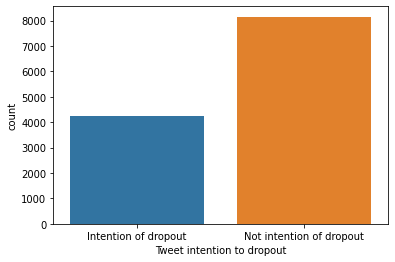

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Number of rows with intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Intention of dropout")]))
print("Number of rows with no intention of dropout: ", 
      len(labeled_dataset_df[(labeled_dataset_df['label'] == "Not intention of dropout")]))

sns.countplot(labeled_dataset_df.label)
plt.xlabel('Tweet intention to dropout');

## **Convert label to numerical value**

In [9]:
# Print categories
print("Categories: ", labeled_dataset_df["label"].astype('category').cat.categories)

# Convert label categorical value to numerical value
label_numerical_value = labeled_dataset_df["label"].astype('category').cat.codes
labeled_dataset_df["label"] = label_numerical_value

Categories:  Index(['Intention of dropout', 'Not intention of dropout'], dtype='object')


## **Filtering irrelevant examples**

In [10]:
IRRELEVANT_KEYWORDS = ["Bernie", "Trump", "Sanders", "to become", 
                       "to pursue", "and becoming", "and going",
                       "and be", "so I can", "so i can", "to run",
                       "to spend", "to focus", "and living", "marry",
                       "stripper", "and joining", "and pursuing",
                       "bts", "BTS", "and running", "to go", "and making",
                       "to dedicate"]

def filtering_irrelevant_examples(twitter_dataset):
  """
  Filtering irrelevant tweets from the Twitter dataset.
  """
  def check_tweet_relevance(tweet):
    """
    Filtering irrelevant tweets from the Twitter dataset.
    """
    if any(indicator in tweet for indicator in IRRELEVANT_KEYWORDS):
      return "irrelevant"
    return "relevant"
  return twitter_dataset[twitter_dataset["tweet"].apply(check_tweet_relevance) \
                         != "irrelevant"]

# Filter the irrelevant tweets
labeled_dataset_df = filtering_irrelevant_examples(labeled_dataset_df)
rows, columns = labeled_dataset_df.shape
print("New number of rows: ", rows)

New number of rows:  10576


## **Convert all letters to lower case**

In [11]:
def convert_letters_to_lower_case(twitter_dataset):
  """
  Convert all letters to lower case.
  """
  def tweet_to_lower_case(tweet):
    """
    Convert tweet text to lower case.
    """
    return tweet.lower()

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(tweet_to_lower_case)

# Convert all tweets to lower case
convert_letters_to_lower_case(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after lower case:")
print(result)

First 10 rows of the DataFrame after lower case:
              id                                              tweet  label
0   1.309219e+18  @justinbieber @chancetherapper i lost both my ...      0
1   1.308809e+18  a curveball here for spector is doing work in ...      1
2   1.308717e+18  "because of the socio-economic fallout of the ...      1
3   1.308484e+18  imagine dropping out of school so you can host...      1
4   1.308352e+18  is #drop_your_school_challenge naming your pas...      1
5   1.307763e+18  girls are quitting school to work in covid-hit...      1
7   1.306801e+18  the pandemic is robbing low-income americans o...      1
8   1.305869e+18  in india, private school head teachers were pa...      1
9   1.305659e+18  what we're you doing at 19? i can almost guara...      1
10  1.305618e+18  dropping out of grad school bc a man on tinder...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove usernames that appear within a tweet**

In [12]:
def remove_usernames_from_tweets(twitter_dataset):
  """
  Remove all usernames that appear on a tweet.
  """
  def remove_username(tweet):
    """
    Remove username from tweet.
    """
    return re.sub('@[\w]+','', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_username)

# Remove all usernames that appear in a tweet
remove_usernames_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id                                              tweet  label
0   1.309219e+18    i lost both my jobs during the pandemic. i t...      0
1   1.308809e+18  a curveball here for spector is doing work in ...      1
2   1.308717e+18  "because of the socio-economic fallout of the ...      1
3   1.308484e+18  imagine dropping out of school so you can host...      1
4   1.308352e+18  is #drop_your_school_challenge naming your pas...      1
5   1.307763e+18  girls are quitting school to work in covid-hit...      1
7   1.306801e+18  the pandemic is robbing low-income americans o...      1
8   1.305869e+18  in india, private school head teachers were pa...      1
9   1.305659e+18  what we're you doing at 19? i can almost guara...      1
10  1.305618e+18  dropping out of grad school bc a man on tinder...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove hashtags that appear within a tweet**

In [13]:
def remove_hashtags_from_tweets(twitter_dataset):
  """
  Remove all hashtags that appear on a tweet.
  """
  def remove_hashtags(tweet):
    """
    Remove hashtags from tweet.
    """
    return tweet.replace("#", "").replace("_", " ")

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_hashtags)

# Remove all hashtags that appear in a tweet
remove_hashtags_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id                                              tweet  label
0   1.309219e+18    i lost both my jobs during the pandemic. i t...      0
1   1.308809e+18  a curveball here for spector is doing work in ...      1
2   1.308717e+18  "because of the socio-economic fallout of the ...      1
3   1.308484e+18  imagine dropping out of school so you can host...      1
4   1.308352e+18  is drop your school challenge naming your past...      1
5   1.307763e+18  girls are quitting school to work in covid-hit...      1
7   1.306801e+18  the pandemic is robbing low-income americans o...      1
8   1.305869e+18  in india, private school head teachers were pa...      1
9   1.305659e+18  what we're you doing at 19? i can almost guara...      1
10  1.305618e+18  dropping out of grad school bc a man on tinder...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove special characters and punctuation that appear within a tweet**

In [14]:
def remove_special_characters_and_punctuation_from_tweets(twitter_dataset):
  """
  Remove all special characters and punctuation that appear on a tweet.
  """
  def remove_special_characters_and_punctuation(tweet):
    """
    Remove special characters and punctuation from tweet.
    """
    return re.sub('[^A-Za-z0-9 ]+', '', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_special_characters_and_punctuation)

# Remove all special characters and punctuation that appear in a tweet
remove_special_characters_and_punctuation_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id                                              tweet  label
0   1.309219e+18    i lost both my jobs during the pandemic i th...      0
1   1.308809e+18  a curveball here for spector is doing work in ...      1
2   1.308717e+18  because of the socioeconomic fallout of the pa...      1
3   1.308484e+18  imagine dropping out of school so you can host...      1
4   1.308352e+18  is drop your school challenge naming your past...      1
5   1.307763e+18  girls are quitting school to work in covidhit ...      1
7   1.306801e+18  the pandemic is robbing lowincome americans of...      1
8   1.305869e+18  in india private school head teachers were par...      1
9   1.305659e+18  what were you doing at 19 i can almost guarant...      1
10  1.305618e+18  dropping out of grad school bc a man on tinder...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove URLs that appear within a tweet**

In [15]:
def remove_urls_from_tweets(twitter_dataset):
  """
  Remove all urls that appear on a tweet.
  """
  def remove_urls(tweet):
    """
    Remove urls from tweet.
    """
    return re.sub(r'http\S+', '', tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_urls)

# Remove all urls that appear in a tweet
remove_urls_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id                                              tweet  label
0   1.309219e+18    i lost both my jobs during the pandemic i th...      0
1   1.308809e+18  a curveball here for spector is doing work in ...      1
2   1.308717e+18  because of the socioeconomic fallout of the pa...      1
3   1.308484e+18  imagine dropping out of school so you can host...      1
4   1.308352e+18  is drop your school challenge naming your past...      1
5   1.307763e+18  girls are quitting school to work in covidhit ...      1
7   1.306801e+18  the pandemic is robbing lowincome americans of...      1
8   1.305869e+18  in india private school head teachers were par...      1
9   1.305659e+18  what were you doing at 19 i can almost guarant...      1
10  1.305618e+18  dropping out of grad school bc a man on tinder...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## **Remove stop words that appear within a tweet**

In [16]:
from gensim.parsing.preprocessing import remove_stopwords

def remove_stop_words_from_tweets(twitter_dataset):
  """
  Remove all stop_words that appear on a tweet.
  """
  def remove_stop_words(tweet):
    """
    Remove stop_words from tweet.
    """
    return remove_stopwords(tweet)

  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(remove_stop_words)

# Remove all stop_words that appear in a tweet
remove_stop_words_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id                                              tweet  label
0   1.309219e+18  lost jobs pandemic got 2 new jobs august let b...      0
1   1.308809e+18  curveball spector work area pandemic clients c...      1
2   1.308717e+18  socioeconomic fallout pandemic billions childr...      1
3   1.308484e+18  imagine dropping school host parties pandemic ...      1
4   1.308352e+18  drop school challenge naming past schools drop...      1
5   1.307763e+18  girls quitting school work covidhit rural indi...      1
7   1.306801e+18  pandemic robbing lowincome americans college d...      1
8   1.305869e+18  india private school head teachers particularl...      1
9   1.305659e+18  19 guarantee wasnt dropping school open restau...      1
10  1.305618e+18  dropping grad school bc man tinder told pandem...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## **Remove short words that appear within a tweet**

In [17]:
def remove_short_words_from_tweets(twitter_dataset):
  """
  Remove all short words that appear on a tweet.
  """
  twitter_dataset["tweet"] = twitter_dataset["tweet"].apply(lambda tweet: ' '.join([word for word in tweet.split() if len(word) > 3]))

# Remove all short_words that appear in a tweet
remove_short_words_from_tweets(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id                                              tweet  label
0   1.309219e+18  lost jobs pandemic jobs august budget cuts hou...      0
1   1.308809e+18  curveball spector work area pandemic clients c...      1
2   1.308717e+18  socioeconomic fallout pandemic billions childr...      1
3   1.308484e+18  imagine dropping school host parties pandemic ...      1
4   1.308352e+18  drop school challenge naming past schools drop...      1
5   1.307763e+18  girls quitting school work covidhit rural indi...      1
7   1.306801e+18  pandemic robbing lowincome americans college d...      1
8   1.305869e+18  india private school head teachers particularl...      1
9   1.305659e+18  guarantee wasnt dropping school open restauran...      1
10  1.305618e+18  dropping grad school tinder told pandemic over...      1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# **Feature Extraction using Sentiment Analysis**

## **Build custom Textblob classifier**

In [ ]:
from textblob import TextBlob 
from textblob import Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.sentiments import NaiveBayesAnalyzer

dropout_common_phrases_to_train = [ 
     ('I am considering dropping out.', 'neg'), 
     ('I want to dropout', 'neg'),
     ('make me contemplate dropping out of school', 'neg'),
     ('Im about to dropout', 'neg'), 
     ('I want to dropout', 'neg'), 
     ('I might have to dropout', 'neg'), 
     ("I am thinking on dropping out", 'neg'), 
     ("I need to dropout", "neg"),
     ("I just want to dropout", 'neg'), 
     ("I just wanna dropout", "neg"),
     ("I am ready to dropout", 'neg'), 
     ("I am going to dropout", "neg"),
     ("I have to dropout", 'neg'), 
     ("I have never wanted to", "neg")
]

textblob_classifier = NaiveBayesClassifier(dropout_common_phrases_to_train) 
textblob_analyzer = NaiveBayesAnalyzer()

## **Create features using sentiment analysis and unigrams and Textblob**

In [ ]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

def calculate_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    tweet_sentiment = TextBlob(tweet, analyzer = textblob_analyzer)
    return tweet_sentiment.sentiment.p_pos
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    tweet_sentiment = TextBlob(tweet, analyzer = textblob_analyzer)
    return tweet_sentiment.sentiment.p_neg

  def calculate_sentiment_tweet_classification(tweet):
    """
    Classify the tweet in positive sentiment or negative sentiment.
    Set 1 to positive sentiment and -1 to negative sentiment
    """
    tweet_sentiment = TextBlob(tweet, classifier = textblob_classifier) 
    sentiment_classification = tweet_sentiment.classify()
    return 1 if sentiment_classification == 'pos' else -1
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if TextBlob(word).polarity < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_textblob_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_textblob_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_textblob_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_textblob_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["unigram_textblob_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["unigram_textblob_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)
  twitter_dataset["unigram_textblob_sentiment_classification"] = twitter_dataset["tweet"].apply(calculate_sentiment_tweet_classification)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... unigram_textblob_sentiment_classification
0   1.309219e+18  ...                                        -1
1   1.308809e+18  ...                                        -1
2   1.308717e+18  ...                                        -1
3   1.308484e+18  ...                                        -1
4   1.308352e+18  ...                                        -1
5   1.307763e+18  ...                                        -1
7   1.306801e+18  ...                                        -1
8   1.305869e+18  ...                                        -1
9   1.305659e+18  ...                                        -1
10  1.305618e+18  ...                                        -1

[10 rows x 10 columns]


## **Create features using sentiment analysis and bigrams and Textblob**

In [ ]:
from textblob import TextBlob

def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_bigram_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["bigram_textblob_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["bigram_textblob_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["bigram_textblob_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["bigram_textblob_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["bigram_textblob_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["bigram_textblob_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_bigram_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... bigram_textblob_negative_score
0   1.309219e+18  ...                            0.0
1   1.308809e+18  ...                           -0.8
2   1.308717e+18  ...                            0.0
3   1.308484e+18  ...                            0.0
4   1.308352e+18  ...                           -0.5
5   1.307763e+18  ...                            0.0
7   1.306801e+18  ...                            0.0
8   1.305869e+18  ...                            0.0
9   1.305659e+18  ...                            0.0
10  1.305618e+18  ...                            0.0

[10 rows x 16 columns]


## **Create features using sentiment analysis and trigrams and Textblob**

In [ ]:
from textblob import TextBlob

def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_trigrams_features_using_polarity(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = TextBlob(ngram).polarity
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if TextBlob(ngram).polarity < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["trigrams_textblob_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["trigrams_textblob_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["trigrams_textblob_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["trigrams_textblob_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["trigrams_textblob_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["trigrams_textblob_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_trigrams_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... trigrams_textblob_negative_score
0   1.309219e+18  ...                             0.00
1   1.308809e+18  ...                            -0.80
2   1.308717e+18  ...                             0.00
3   1.308484e+18  ...                             0.00
4   1.308352e+18  ...                            -0.75
5   1.307763e+18  ...                             0.00
7   1.306801e+18  ...                             0.00
8   1.305869e+18  ...                             0.00
9   1.305659e+18  ...                             0.00
10  1.305618e+18  ...                             0.00

[10 rows x 22 columns]


## **Create features using sentiment analysis and unigrams and Vader**

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

In [ ]:
def calculate_features_using_polarity_vader(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      if sentiment_analyzer.polarity_scores(word)["compound"] < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_vader_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_vader_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_vader(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... unigram_vader_ratio_negative_words
0   1.309219e+18  ...                           0.214286
1   1.308809e+18  ...                           0.050000
2   1.308717e+18  ...                           0.136364
3   1.308484e+18  ...                           0.285714
4   1.308352e+18  ...                           0.200000
5   1.307763e+18  ...                           0.100000
7   1.306801e+18  ...                           0.090909
8   1.305869e+18  ...                           0.058824
9   1.305659e+18  ...                           0.125000
10  1.305618e+18  ...                           0.076923

[10 rows x 26 columns]


## **Create features using sentiment analysis and bigrams and Vader**

In [ ]:
def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_bigram_vader_features_using_polarity(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] > 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] >= 0:
        number_of_positive_bigrams = number_of_positive_bigrams + 1
    return number_of_positive_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_bigrams = 0
    ngrams = find_ngrams(2, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_bigrams = number_of_negative_bigrams + 1
    return number_of_negative_bigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["bigram_vader_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["bigram_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["bigram_vader_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["bigram_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["bigram_vader_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["bigram_vader_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_bigram_vader_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... bigram_vader_negative_score
0   1.309219e+18  ...                     -1.4110
1   1.308809e+18  ...                     -0.5464
2   1.308717e+18  ...                     -1.2982
3   1.308484e+18  ...                     -0.8424
4   1.308352e+18  ...                     -0.8196
5   1.307763e+18  ...                     -1.0403
7   1.306801e+18  ...                     -1.6612
8   1.305869e+18  ...                     -0.5464
9   1.305659e+18  ...                     -0.2732
10  1.305618e+18  ...                     -0.5984

[10 rows x 32 columns]


## **Create features using sentiment analysis and trigrams and Vader**

In [ ]:
def find_ngrams(n, input_sequence):
  # Split sentence into tokens.
  tokens = input_sequence.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    # Take n consecutive tokens in array.
    ngram = tokens[i:i+n]
    # Concatenate array items into string.
    ngram = ' '.join(ngram)
    ngrams.append(ngram)
  return ngrams

def calculate_trigrams_vader_features_using_polarity(twitter_dataset):
  """
  Use Vader polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] > 0:
        number_of_positive_trigrams = number_of_positive_trigrams + 1
    return number_of_positive_trigrams
  
  def calculate_positive_tweet_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score > 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] >= 0:
        number_of_positive_trigrams = number_of_positive_trigrams + 1
    return number_of_positive_trigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_trigrams = number_of_negative_trigrams + 1
    return number_of_negative_trigrams
  
  def calculate_negative_tweet_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    score = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      polarity_score = sentiment_analyzer.polarity_scores(ngram)["compound"]
      if polarity_score < 0:
        score = score + polarity_score
    return score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_trigrams = 0
    ngrams = find_ngrams(3, tweet)
    for ngram in ngrams:
      if sentiment_analyzer.polarity_scores(ngram)["compound"] < 0:
        number_of_negative_trigrams = number_of_negative_trigrams + 1
    return number_of_negative_trigrams/len(ngrams) if len(ngrams) != 0 else 0
  
  twitter_dataset["trigrams_vader_number_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["trigrams_vader_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["trigrams_vader_number_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["trigrams_vader_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)
  twitter_dataset["trigrams_vader_positive_score"] = twitter_dataset["tweet"].apply(calculate_positive_tweet_score)
  twitter_dataset["trigrams_vader_negative_score"] = twitter_dataset["tweet"].apply(calculate_negative_tweet_score)

# Calculate new features using sentiment Analysis
calculate_trigrams_vader_features_using_polarity(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... trigrams_vader_negative_score
0   1.309219e+18  ...                       -1.9574
1   1.308809e+18  ...                       -0.8196
2   1.308717e+18  ...                       -1.6741
3   1.308484e+18  ...                       -0.8424
4   1.308352e+18  ...                       -1.0928
5   1.307763e+18  ...                       -1.2610
7   1.306801e+18  ...                       -1.8635
8   1.305869e+18  ...                       -0.8196
9   1.305659e+18  ...                       -0.2732
10  1.305618e+18  ...                       -0.9236

[10 rows x 38 columns]


## **Create features using sentiment analysis and unigrams and Flair**

In [ ]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2020-11-25 16:12:54,923 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_3.1.pt not found in cache, downloading to /tmp/tmpgmi4dha7


100%|██████████| 266147697/266147697 [00:07<00:00, 37071555.47B/s]

2020-11-25 16:13:02,167 copying /tmp/tmpgmi4dha7 to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2020-11-25 16:13:02,881 removing temp file /tmp/tmpgmi4dha7
2020-11-25 16:13:04,577 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


In [ ]:
def calculate_features_using_polarity_flair(twitter_dataset):
  """
  Use flair polarity to calculate the number of positive and negative words.
  """
  def calculate_positive_words(tweet):
    """
    Count number of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words
  
  def calculate_positive_words_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    positive_words_score = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        positive_words_score = positive_words_score + s.labels[0].score
    return positive_words_score
  
  def calculate_ratio_positive_words(tweet):
    """
    Calculate the ratio of positive words in a tweet.
    """
    number_of_positive_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score > 0:
        number_of_positive_words = number_of_positive_words + 1
    return number_of_positive_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  def calculate_negative_words(tweet):
    """
    Count number of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words
  
  def calculate_negative_words_score(tweet):
    """
    Count number of negative words in a tweet.
    """
    negative_words_score = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        negative_words_score = negative_words_score + s.labels[0].score
    return negative_words_score
  
  def calculate_ratio_negative_words(tweet):
    """
    Calculate the ratio of negative words in a tweet.
    """
    number_of_negative_words = 0
    for word in tweet.split():
      s = flair.data.Sentence(word)
      flair_sentiment.predict(s)
      if s.labels[0].score < 0:
        number_of_negative_words = number_of_negative_words + 1
    return number_of_negative_words/len(tweet.split()) if len(tweet.split()) != 0 else 0
  
  twitter_dataset["unigram_flair_positive_words"] = twitter_dataset["tweet"].apply(calculate_positive_words)
  twitter_dataset["unigram_flair_positive_words_score"] = twitter_dataset["tweet"].apply(calculate_positive_words_score)
  twitter_dataset["unigram_flair_ratio_positive_words"] = twitter_dataset["tweet"].apply(calculate_ratio_positive_words)
  twitter_dataset["unigram_flair_negative_words"] = twitter_dataset["tweet"].apply(calculate_negative_words)
  twitter_dataset["unigram_flair_negative_words_score"] = twitter_dataset["tweet"].apply(calculate_negative_words_score)
  twitter_dataset["unigram_flair_ratio_negative_words"] = twitter_dataset["tweet"].apply(calculate_ratio_negative_words)

# Calculate new features using sentiment Analysis
# calculate_features_using_polarity_flair(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

First 10 rows of the DataFrame after removing usernames:
              id  ... trigrams_vader_negative_score
0   1.309219e+18  ...                       -1.9574
1   1.308809e+18  ...                       -0.8196
2   1.308717e+18  ...                       -1.6741
3   1.308484e+18  ...                       -0.8424
4   1.308352e+18  ...                       -1.0928
5   1.307763e+18  ...                       -1.2610
7   1.306801e+18  ...                       -1.8635
8   1.305869e+18  ...                       -0.8196
9   1.305659e+18  ...                       -0.2732
10  1.305618e+18  ...                       -0.9236

[10 rows x 38 columns]


In [ ]:
s = flair.data.Sentence("dropping out of school")
flair_sentiment.predict(s)
s

Sentence: "dropping out of school"   [− Tokens: 4  − Sentence-Labels: {'label': [NEGATIVE (0.9851)]}]

 ## **Add Polarity Score of the entire tweet as a feature**

In [ ]:
from textblob import TextBlob

def calculate_features_using_polarity_score(twitter_dataset):
  """
  Use Textblob polarity to calculate the number of positive and negative words.
  """
  def calculate_textblob_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    return TextBlob(tweet).polarity
  
  def calculate_vader_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    return sentiment_analyzer.polarity_scores(tweet)["compound"]
  
  def calculate_flair_score(tweet):
    """
    Count number of positive words in a tweet.
    """
    s = flair.data.Sentence(tweet)
    flair_sentiment.predict(s)
    return s.labels[0].score if len(s.labels) > 0 else 0
  
  twitter_dataset["unigram_textblob_score"] = twitter_dataset["tweet"].apply(calculate_textblob_score)
  twitter_dataset["unigram_vader_score"] = twitter_dataset["tweet"].apply(calculate_vader_score)
  twitter_dataset["unigram_flair_score"] = twitter_dataset["tweet"].apply(calculate_flair_score)

# Calculate new features using sentiment Analysis
calculate_features_using_polarity_score(labeled_dataset_df)

# Show results
result = labeled_dataset_df.head(10)
print("First 10 rows of the DataFrame after removing usernames:")
print(result)

2020-11-25 16:13:23,034 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,046 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,097 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,224 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,234 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,244 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,253 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,254 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,266 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-11-25 16:13:23,268 Warning: An empty Sentence was 

## **Download Pandas Dataframe that contains all the extracted features**

In [ ]:
#from google.colab import files
#labeled_dataset_df.to_csv('dropping_out_tweets_labeled_with_features.csv')
#files.download('dropping_out_tweets_labeled_with_features.csv')

## **Create dictionary that contains all the names of the extracted features**

In [ ]:
SENTIMENT_ANALYSIS_FEATURES_DICT = {
    "textblob_unigram_features" : ["unigram_textblob_number_positive_words",
                                   "unigram_textblob_ratio_positive_words",
                                   "unigram_textblob_number_negative_words",
                                   "unigram_textblob_ratio_negative_words",
                                   "unigram_textblob_positive_score",
                                   "unigram_textblob_negative_score",
                                   "unigram_textblob_score"],
    "textblob_bigram_features" : ["bigram_textblob_ratio_positive_words",
                                  "bigram_textblob_number_negative_words",
                                  "bigram_textblob_ratio_negative_words",
                                  "bigram_textblob_positive_score",
                                  "bigram_textblob_negative_score"],
    "textblob_trigram_features" : ["trigrams_textblob_ratio_positive_words",
                                   "trigrams_textblob_number_negative_words",
                                   "trigrams_textblob_ratio_negative_words",
                                   "trigrams_textblob_positive_score",
                                   "trigrams_textblob_negative_score"],  
    "vader_unigram_features" : ["unigram_vader_positive_words", 
                                "unigram_vader_ratio_positive_words", 
                                "unigram_vader_negative_words", 
                                "unigram_vader_ratio_negative_words",
                                "unigram_vader_score"],
    "vader_bigram_features" : ["bigram_vader_number_positive_words", 
                               "bigram_vader_ratio_positive_words", 
                               "bigram_vader_number_negative_words", 
                               "bigram_vader_ratio_negative_words",
                               "bigram_vader_positive_score",
                               "bigram_vader_negative_score"],
    "vader_trigram_features" : ["trigrams_vader_number_positive_words", 
                                "trigrams_vader_ratio_positive_words", 
                                "trigrams_vader_number_negative_words", 
                                "trigrams_vader_ratio_negative_words",
                                "trigrams_vader_positive_score",
                                "trigrams_vader_negative_score"],
    "flair_unigram_features" : ["unigram_flair_score"]                                                                      
}

# **Feature Extraction using Bag of Words, TF-IDF and Word2Vec**

## **Tweets preprocessing before Feature Extraction**

### **Tokenization of all the tweets before normalization**

In [ ]:
tokenized_tweet_df = labeled_dataset_df.tweet.apply(lambda tweet: tweet.split())
tokenized_tweet_df.head()

0    [lost, job, pandem, job, august, budget, cut, ...
1    [curvebal, spector, work, area, pandem, client...
2    [socioeconom, fallout, pandem, billion, childr...
3    [imagin, drop, school, host, parti, pandem, em...
4    [drop, school, challeng, name, past, school, d...
Name: tweet, dtype: object

### **Normalization of the tokenized tweets**

In [ ]:
from nltk.stem.porter import * 

stemmer = PorterStemmer() 
tokenized_tweet_df = tokenized_tweet_df.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet_df.head()

0    [lost, job, pandem, job, august, budget, cut, ...
1    [curveb, spector, work, area, pandem, client, ...
2    [socioeconom, fallout, pandem, billion, childr...
3    [imagin, drop, school, host, parti, pandem, em...
4    [drop, school, challeng, name, past, school, d...
Name: tweet, dtype: object

### **Stitch tokens back together into tweets**

In [ ]:
for i in range(len(tokenized_tweet_df)):
    tokenized_tweet_df.iloc[i] = ' '.join(tokenized_tweet_df.iloc[i])    
labeled_dataset_df['tweet'] = tokenized_tweet_df

## **Bag of words features**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, 
                                 stop_words='english')
bow = bow_vectorizer.fit_transform(labeled_dataset_df['tweet'])
bow.shape

(10576, 1000)

## **TD-IDF features**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, 
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(labeled_dataset_df['tweet'])
tfidf.shape

(10576, 1000)

## **Word2Vec features**

### **Train the Word2Vec model**

In [ ]:
tokenized_tweet = labeled_dataset_df['tweet'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200,
            window=5,
            min_count=2,                                 
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 32,
            seed = 34
) 

model_w2v.train(tokenized_tweet, 
                total_examples = len(labeled_dataset_df['tweet']), 
                epochs=20)

(1848558, 2568620)

### **Create a vector for each tweet**

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

### **Preparing Word2Vec features set**

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet.iloc[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(10576, 200)

# **Tweets Statistics**

## **Create WordCloud of most used sentiment words in all the tweets**

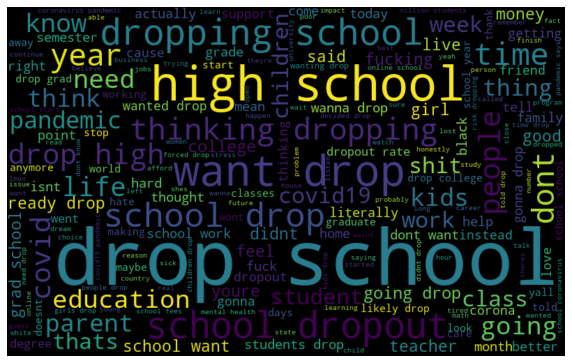

In [ ]:
all_words = ' '.join([tweet for tweet in labeled_dataset_df['tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, 
                      max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

## **Create WordCloud of most used sentiment words in all the tweets with intention to dropout**

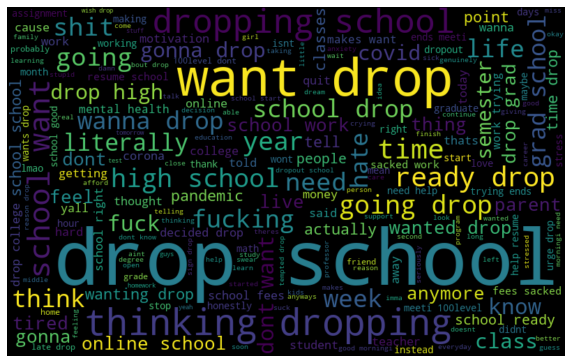

In [ ]:
positive_words = ' '.join([tweet for tweet in labeled_dataset_df['tweet'][labeled_dataset_df['label'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, 
                      max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Create WordCloud of most used sentiment words in all the tweets with no intention to dropout**

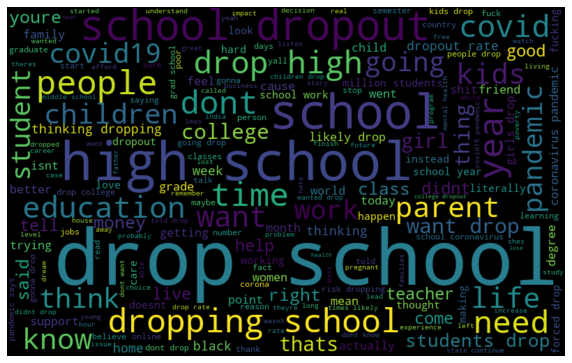

In [ ]:
negative_words = ' '.join([tweet for tweet in labeled_dataset_df['tweet'][labeled_dataset_df['label'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, 
                      max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Create Plot with most frequent positive words in all the tweets**

Text(0.5, 1.0, 'Most frequent positive words')

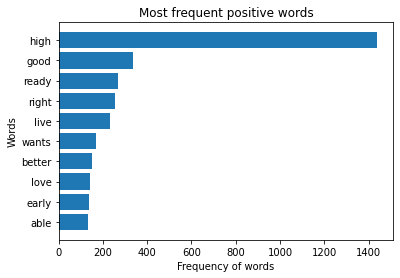

In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import operator

def calculate_most_frequently_n_positive_words(twitter_dataset, number_of_words):
  """
  Use Textblob polarity to calculate the most frequently positive words.
  """
  def calculate_most_frequently_positive_words(tweet_column):
    """
    Count number of positive words in a tweet.
    """
    positive_words_dict = dict()
    tweets_list = tweet_column.values
    for tweet in tweets_list:
      for word in tweet.split():
        if TextBlob(word).polarity > 0:
          if word in positive_words_dict:
            positive_words_dict[word] = positive_words_dict[word] + 1
          else:
            positive_words_dict[word] = 1

    return dict(sorted(positive_words_dict.items(), key = operator.itemgetter(1), 
                       reverse = True)[:number_of_words])
  
  return calculate_most_frequently_positive_words(twitter_dataset["tweet"])


# Calculate most frequently positive words
frequent_positive_words_dict = calculate_most_frequently_n_positive_words(labeled_dataset_df,  
                                                                          number_of_words = 10)

# Plot the most frequent positive words in a bar chart
fig, ax = plt.subplots()
ax.barh(*zip(*frequent_positive_words_dict.items()))
ax.invert_yaxis()
ax.set_xlabel('Frequency of words')
ax.set_ylabel('Words')
ax.set_title('Most frequent positive words')

## **Create Plot with most frequent negative words in all the tweets**

Text(0.5, 1.0, 'Most frequent negative words')

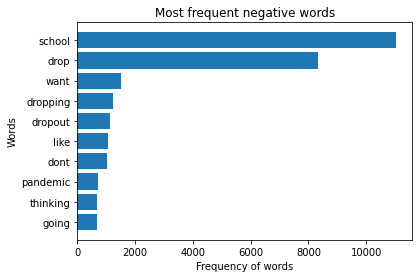

In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import operator

def calculate_most_frequently_n_negative_words(twitter_dataset, number_of_words):
  """
  Use Textblob polarity to calculate the most frequently negative words.
  """
  def calculate_most_frequently_negative_words(tweet_column):
    """
    Count number of negative words in a tweet.
    """
    negative_words_dict = dict()
    tweets_list = tweet_column.values
    for tweet in tweets_list:
      for word in tweet.split():
        if TextBlob(word).polarity <= 0:
          if word in negative_words_dict:
            negative_words_dict[word] = negative_words_dict[word] + 1
          else:
            negative_words_dict[word] = 1

    return dict(sorted(negative_words_dict.items(), key = operator.itemgetter(1), 
                       reverse = True)[:number_of_words])
  
  return calculate_most_frequently_negative_words(twitter_dataset["tweet"])


# Calculate most frequently negative words
frequent_negative_words_dict = calculate_most_frequently_n_negative_words(labeled_dataset_df,  
                                                                          number_of_words = 10)

# Plot the most frequent negative words in a bar chart
fig, ax = plt.subplots()
ax.barh(*zip(*frequent_negative_words_dict.items()))
ax.invert_yaxis()
ax.set_xlabel('Frequency of words')
ax.set_ylabel('Words')
ax.set_title('Most frequent negative words')

# **Model training using Sentiment Analysis Features**

## **Training the models using only the Textblob Features**

### **Select the Textblob Features**

In [ ]:
# Select calculated Textblob features
textblob_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_unigram_features"] + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_bigram_features"]  + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_trigram_features"]

# Select the Texblob features from the Dataset
dataset_sentiment_features = labeled_dataset_df[textblob_features_list]

### **Normalize calculated features using Scaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

### **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

### **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

### **Logistic Regression Model**

In [ ]:
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(random_state = 0).fit(X_train,
                                                               Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.669813865659563
Training Precision:  0.7205270457697642
Training Recall:  0.5586021505376344
Training F-measure:  0.6293155663234404

Test Accuracy:  0.6803308162531464
Test Precision:  0.7136524822695035
Test Recall:  0.587162654996353
Test F-measure:  0.6442577030812325


### **Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6411293948385937
Training Precision:  0.6888519134775375
Training Recall:  0.5193548387096775
Training F-measure:  0.5922141616429959

Test Accuracy:  0.6508450197770587
Test Precision:  0.6858736059479554
Test Recall:  0.5382932166301969
Test F-measure:  0.6031875766244381


### **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6243143602194048
Training Precision:  0.6831243469174504
Training Recall:  0.46863799283154123
Training F-measure:  0.5559098639455783

Test Accuracy:  0.6357425386551601
Test Precision:  0.6804435483870968
Test Recall:  0.4923413566739606
Test F-measure:  0.5713076597545493


### **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6668465066091179
Training Precision:  0.7255232138561463
Training Recall:  0.5405017921146953
Training F-measure:  0.6194926568758344

Test Accuracy:  0.670262495505214
Test Precision:  0.7105751391465677
Test Recall:  0.5587162654996353
Test F-measure:  0.6255614536545528


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42,
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.749213200251776
Training Precision:  0.7555392785204175
Training Recall:  0.739426523297491
Training F-measure:  0.7473960691966306

Test Accuracy:  0.7069399496583962
Test Precision:  0.698005698005698
Test Recall:  0.7148067104303428
Test F-measure:  0.7063063063063064


### **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7484039205107454
Training Precision:  0.758166295471418
Training Recall:  0.732078853046595
Training F-measure:  0.7448942377826404

Test Accuracy:  0.7094570298453794
Test Precision:  0.7026637868970482
Test Recall:  0.711889132020423
Test F-measure:  0.7072463768115942


## **Training the models using only the Vader Features**

### **Select the Vader Features**

In [ ]:
# Select calculated Vader features
vader_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["vader_unigram_features"] + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_bigram_features"]  + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_trigram_features"]

# Select the Vader features from the Dataset
dataset_sentiment_features = labeled_dataset_df[vader_features_list]

### **Select the best features**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Feature extraction
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(dataset_sentiment_features, labeled_dataset_df.label)

# Set the best features
dataset_sentiment_features = fit.transform(dataset_sentiment_features)

### **Normalize calculated features using Scaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

### **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

### **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

### **Logistic Regression Model**

In [ ]:
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression().fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7059616940922578
Training Precision:  0.6839592616168045
Training Recall:  0.7699749193837334
Training F-measure:  0.7244227203775493

Test Accuracy:  0.7184466019417476
Test Precision:  0.6890322580645162
Test Recall:  0.7801314828341855
Test F-measure:  0.7317574511819117


### **Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6615406320541761
Training Precision:  0.6321942446043165
Training Recall:  0.7865734265734265
Training F-measure:  0.7009846690764053

Test Accuracy:  0.6568848758465011
Test Precision:  0.6150978564771669
Test Recall:  0.7719298245614035
Test F-measure:  0.6846473029045644


### **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6826724215448251
Training Precision:  0.6677013559875837
Training Recall:  0.7321748477248298
Training F-measure:  0.6984533880201658

Test Accuracy:  0.6911183027687882
Test Precision:  0.6690981432360743
Test Recall:  0.7370343316289262
Test F-measure:  0.7014250955856794


### **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7150436111860444
Training Precision:  0.7076949561025994
Training Recall:  0.7364743819419562
Training F-measure:  0.7217979106312

Test Accuracy:  0.724559510967278
Test Precision:  0.7075017205781142
Test Recall:  0.7509130752373996
Test F-measure:  0.7285613040396882


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7630608758205197
Training Precision:  0.7611199716462874
Training Recall:  0.7694374776065926
Training F-measure:  0.7652561247216035

Test Accuracy:  0.7590794678173319
Test Precision:  0.7487544483985765
Test Recall:  0.7684441197954711
Test F-measure:  0.7584715212689257


### **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7689056739501844
Training Precision:  0.7689285714285714
Training Recall:  0.7714080974561089
Training F-measure:  0.7701663387587193

Test Accuracy:  0.7605177993527508
Test Precision:  0.7541576283441793
Test Recall:  0.7618699780861943
Test F-measure:  0.7579941860465115


## **Training the models using Vader and Textblob Features**

### **Select the Vader and Textblob Features**

In [ ]:
# Select calculated Vader and Textblob features
textblob_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_unigram_features"] + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_bigram_features"]  + \
                         SENTIMENT_ANALYSIS_FEATURES_DICT["textblob_trigram_features"]

vader_features_list = SENTIMENT_ANALYSIS_FEATURES_DICT["vader_unigram_features"] + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_bigram_features"]  + \
                      SENTIMENT_ANALYSIS_FEATURES_DICT["vader_trigram_features"]

# Select the Vader features from the Dataset
dataset_sentiment_features = labeled_dataset_df[vader_features_list + textblob_features_list]

### **Select the best features**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Feature extraction
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(dataset_sentiment_features, labeled_dataset_df.label)

# Set the best features
dataset_sentiment_features = fit.transform(dataset_sentiment_features)

### **Normalize calculated features using Scaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Normalize using the mean value
sc = StandardScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(dataset_sentiment_features)

### **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return dataset_sentiment_features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

### **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

### **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

### **Logistic Regression Model**

In [ ]:
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(random_state = 0).fit(X_train,
                                                               Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6966999370560202
Training Precision:  0.6780889621087315
Training Recall:  0.7436314363143631
Training F-measure:  0.7093494183541577

Test Accuracy:  0.6943545487234808
Test Precision:  0.6844850065189049
Test Recall:  0.7415254237288136
Test F-measure:  0.711864406779661


### **Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.690045859185325
Training Precision:  0.6759352881698686
Training Recall:  0.7246612466124661
Training F-measure:  0.699450693172901

Test Accuracy:  0.6842862279755484
Test Precision:  0.6795727636849133
Test Recall:  0.7189265536723164
Test F-measure:  0.6986959505833906


### **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6870785001348799
Training Precision:  0.6786645800730308
Training Recall:  0.7051490514905149
Training F-measure:  0.6916533758639021

Test Accuracy:  0.6806903991370011
Test Precision:  0.6815680880330124
Test Recall:  0.6998587570621468
Test F-measure:  0.6905923344947735


### **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.706860893804514
Training Precision:  0.7007943512797882
Training Recall:  0.7172538392050587
Training F-measure:  0.7089285714285715

Test Accuracy:  0.6961524631427544
Test Precision:  0.7029140014214641
Test Recall:  0.6984463276836158
Test F-measure:  0.7006730428622032


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7566765578635015
Training Precision:  0.7486377219194937
Training Recall:  0.7694670280036133
Training F-measure:  0.7589094796863862

Test Accuracy:  0.7306724199928083
Test Precision:  0.732080723729993
Test Recall:  0.7429378531073446
Test F-measure:  0.7374693305292674


### **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7751101519647514
Training Precision:  0.7718637992831541
Training Recall:  0.7781391147244806
Training F-measure:  0.7749887539361223

Test Accuracy:  0.7331895001797915
Test Precision:  0.7369901547116737
Test Recall:  0.7401129943502824
Test F-measure:  0.7385482734319944


# **Model training using Word2Vec Features**

## **Reducing Dimensionality**

In [ ]:
from sklearn.decomposition import PCA

def reduce_wordvec_df_dimensionality(wordvec_df, number_of_dimensions):
    pca = PCA(number_of_dimensions)
    reduce_df = pd.DataFrame(pca.fit_transform(wordvec_df))
    return reduce_df

wordvec_df = reduce_wordvec_df_dimensionality(wordvec_df, 10)

## **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(wordvec_df)

## **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return wordvec_df, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7787968707850014
Training Precision:  0.7971590909090909
Training Recall:  0.7518756698821008
Training F-measure:  0.7738554881412024

Test Accuracy:  0.7874865156418555
Test Precision:  0.7917304747320061
Test Recall:  0.7642276422764228
Test F-measure:  0.7777359909740504


In [ ]:
print(classification_report(Y_test, Y_pred))

## **Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7630608758205197
Training Precision:  0.824819118614339
Training Recall:  0.6720257234726688
Training F-measure:  0.74062407717295

Test Accuracy:  0.777418194893923
Test Precision:  0.8213660245183888
Test Recall:  0.6932742054693274
Test F-measure:  0.7519038076152305


## **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7967808650301232
Training Precision:  0.8513684210526316
Training Recall:  0.722400857449089
Training F-measure:  0.7816003092385002

Test Accuracy:  0.8033081625314635
Test Precision:  0.8492201039861352
Test Recall:  0.7243163340724317
Test F-measure:  0.7818109293976865


In [ ]:
print(classification_report(Y_test, Y_pred))

## **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7592842370290441
Training Precision:  0.7370556727803927
Training Recall:  0.8111825652018578
Training F-measure:  0.7723445871247554

Test Accuracy:  0.7580007191657677
Test Precision:  0.7199223803363519
Test Recall:  0.8226164079822617
Test F-measure:  0.76785098309762


In [ ]:
print(classification_report(Y_test, Y_pred))

## **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8158438989299523
Training Precision:  0.8534448426921545
Training Recall:  0.7656305823508396
Training F-measure:  0.807156308851224

Test Accuracy:  0.8000719165767709
Test Precision:  0.8258381030253475
Test Recall:  0.7464892830746489
Test F-measure:  0.7841614906832298


In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1428
           1       0.82      0.77      0.79      1353

    accuracy                           0.80      2781
   macro avg       0.81      0.80      0.80      2781
weighted avg       0.80      0.80      0.80      2781



## **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8161136588436292
Training Precision:  0.8467694710130783
Training Recall:  0.77491961414791
Training F-measure:  0.809252868202593

Test Accuracy:  0.804027328299173
Test Precision:  0.819620253164557
Test Recall:  0.7657058388765706
Test F-measure:  0.7917462743599541


In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1428
           1       0.82      0.77      0.79      1353

    accuracy                           0.80      2781
   macro avg       0.81      0.80      0.80      2781
weighted avg       0.80      0.80      0.80      2781



# **Model training using TF-IDF Features**

## **Reducing Dimensionality**

In [ ]:
from sklearn.decomposition import TruncatedSVD

def reduce_tfidf_dimensionality(tfidf, number_of_dimensions):
    tsvd = TruncatedSVD(n_components = number_of_dimensions)
    reduce_df = pd.DataFrame(tsvd.fit_transform(tfidf))
    return reduce_df

tfidf = reduce_tfidf_dimensionality(tfidf, 10)

## **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(tfidf)

## **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return tfidf, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7548781584389893
Training Precision:  0.7623871799594769
Training Recall:  0.7424215246636772
Training F-measure:  0.752271901126863

Test Accuracy:  0.7411003236245954
Test Precision:  0.7458770614692654
Test Recall:  0.7231104651162791
Test F-measure:  0.7343173431734318


## **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7680963942091539
Training Precision:  0.8002004008016032
Training Recall:  0.7162331838565023
Training F-measure:  0.7558920965451964

Test Accuracy:  0.7468536497662711
Test Precision:  0.7740619902120718
Test Recall:  0.6896802325581395
Test F-measure:  0.7294388931591084


## **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6670263465515691
Training Precision:  0.6213692946058091
Training Recall:  0.8595515695067265
Training F-measure:  0.7213065402272899

Test Accuracy:  0.6533620999640417
Test Precision:  0.6075156576200418
Test Recall:  0.8459302325581395
Test F-measure:  0.707168894289186


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8010071036777269
Training Precision:  0.8335317460317461
Training Recall:  0.753542600896861
Training F-measure:  0.7915214319359398

Test Accuracy:  0.7551240560949298
Test Precision:  0.7786688051323175
Test Recall:  0.7056686046511628
Test F-measure:  0.7403736179946626


## **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7977699847136049
Training Precision:  0.8249316139116842
Training Recall:  0.7573094170403587
Training F-measure:  0.7896754886374263

Test Accuracy:  0.7533261416756563
Test Precision:  0.7742448330683624
Test Recall:  0.7078488372093024
Test F-measure:  0.7395596051632498


# **Model training using Bag of Words Features**

## **Reducing Dimensionality**

In [ ]:
from sklearn.decomposition import TruncatedSVD

def reduce_bow_dimensionality(bow, number_of_dimensions):
    tsvd = TruncatedSVD(n_components = number_of_dimensions)
    reduce_df = pd.DataFrame(tsvd.fit_transform(bow))
    return reduce_df

bow = reduce_bow_dimensionality(bow, 10)

## **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(bow)

### **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return bow, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7207085693732578
Training Precision:  0.7942289498580889
Training Recall:  0.6002860207365034
Training F-measure:  0.6837711260435756

Test Accuracy:  0.732470334412082
Test Precision:  0.7972841901066925
Test Recall:  0.6057479734708917
Test F-measure:  0.6884422110552764


## **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7369840841650931
Training Precision:  0.8126024830171
Training Recall:  0.6201287093314265
Training F-measure:  0.7034370881070668

Test Accuracy:  0.7443365695792881
Test Precision:  0.812984496124031
Test Recall:  0.6182756079587325
Test F-measure:  0.702385935537882


## **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.6116356442765938
Training Precision:  0.5749559082892416
Training Recall:  0.8741508759385055
Training F-measure:  0.6936662174622313

Test Accuracy:  0.6030204962243797
Test Precision:  0.5585919407132932
Test Recall:  0.8887251289609432
Test F-measure:  0.6860068259385665


### **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7840122291160867
Training Precision:  0.8002257336343115
Training Recall:  0.7604576331784054
Training F-measure:  0.7798350137488542

Test Accuracy:  0.7551240560949298
Test Precision:  0.7632398753894081
Test Recall:  0.7221812822402358
Test F-measure:  0.7421431276031806


## **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7857207085693733
Training Precision:  0.7948576675849404
Training Recall:  0.7736860922416875
Training F-measure:  0.7841289971917745

Test Accuracy:  0.7533261416756563
Test Precision:  0.7532075471698113
Test Recall:  0.735445836403832
Test F-measure:  0.744220730797912


# **Model training using BERT embeddings**

## **Install transformers library**

In [ ]:
!pip install transformers

## **Import necessary libraries**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings

warnings.filterwarnings('ignore')

## **Load pretrained BERT model**

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenizer.encode("I want to drop out of school", add_special_tokens=True)

[101, 1045, 2215, 2000, 4530, 2041, 1997, 2082, 102]

In [ ]:
text = "I want to drop out of school"
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'i', 'want', 'to', 'drop', 'out', 'of', 'school', '[SEP]']


## **Select datasets to process**

In [ ]:
bert_dataset1 = labeled_dataset_df.iloc[0:3200]
bert_dataset2 = labeled_dataset_df.iloc[3200:5000]
bert_dataset3 = labeled_dataset_df.iloc[5000:7000]

## **Tokenize tweets using BERT Tokenizer**

In [ ]:
tokenized_tweets_dataset1 = bert_dataset1["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))
tokenized_tweets_dataset2 = bert_dataset2["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))
tokenized_tweets_dataset3 = bert_dataset3["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))

## **Padded tokenize tweets values**

In [ ]:
max_len = 0
for i in tokenized_tweets_dataset1.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tokenize_tweets_dataset1 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tweets_dataset1.values])

max_len = 0
for i in tokenized_tweets_dataset2.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tokenize_tweets_dataset2 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tweets_dataset2.values])

max_len = 0
for i in tokenized_tweets_dataset3.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tokenize_tweets_dataset3 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tweets_dataset3.values])

## **Add the attention mask**

In [ ]:
attention_mask_dataset1 = np.where(padded_tokenize_tweets_dataset1 != 0, 1, 0)
attention_mask_dataset2 = np.where(padded_tokenize_tweets_dataset2 != 0, 1, 0)
attention_mask_dataset3 = np.where(padded_tokenize_tweets_dataset3 != 0, 1, 0)

## **Get BERT Embeddings after fine-tuning**

In [ ]:
total_number_of_rows, total_number_of_columns = labeled_dataset_df.shape
bert_features = []

# Select number of iterations
iterations = total_number_of_rows//2000

i = 0
j = 2000
while j != -2:
  # Select batch dataset
  bert_dataset = labeled_dataset_df.iloc[i:j]

  # Tokenize first batch
  tokenized_tweets_dataset = bert_dataset["tweet"].apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))

  # Padded tokenized batch
  max_len = 0
  for k in tokenized_tweets_dataset.values:
      if len(k) > max_len:
          max_len = len(k)
  padded_tokenize_tweets_dataset = np.array([n + [0]*(max_len-len(n)) for n in tokenized_tweets_dataset.values])

  # Add attention mask
  attention_mask_dataset = np.where(padded_tokenize_tweets_dataset != 0, 1, 0)

  # Calculate the sentence embeddings
  input_tweets_ids_dataset = torch.tensor(padded_tokenize_tweets_dataset)  
  attention_mask_dataset = torch.tensor(attention_mask_dataset)
  with torch.no_grad():
      last_hidden_states_dataset = bert_model(input_tweets_ids_dataset, 
                                              attention_mask = attention_mask_dataset)
  
  # Append Batch BERT features
  features_dataset = last_hidden_states_dataset[0][:,0,:].numpy()
  if np.array_equal(bert_features, []):
    bert_features = features_dataset
  else:
    bert_features = np.concatenate((bert_features, features_dataset), axis=0)

  # Update i and j pointers
  i = j
  if j + 2000 <= total_number_of_rows:
    j = j + 2000
  else:
    if j == total_number_of_rows:
      j = -2
    elif j < total_number_of_rows:
      j = total_number_of_rows

## **Calculate the BERT Features for dataset 1**

In [ ]:
input_tweets_ids_dataset1 = torch.tensor(padded_tokenize_tweets_dataset1)  
attention_mask_dataset1 = torch.tensor(attention_mask_dataset1)

with torch.no_grad():
    last_hidden_states_dataset1 = bert_model(input_tweets_ids_dataset1, 
                                             attention_mask = attention_mask_dataset1)

## **Calculate the BERT Features for dataset 2**

In [ ]:
input_tweets_ids_dataset2 = torch.tensor(padded_tokenize_tweets_dataset2)  
attention_mask_dataset2 = torch.tensor(attention_mask_dataset2)

with torch.no_grad():
    last_hidden_states_dataset2 = bert_model(input_tweets_ids_dataset2, 
                                             attention_mask = attention_mask_dataset2)

## **Calculate the BERT Features for dataset 3**

In [ ]:
input_tweets_ids_dataset3 = torch.tensor(padded_tokenize_tweets_dataset3)  
attention_mask_dataset3 = torch.tensor(attention_mask_dataset3)

with torch.no_grad():
    last_hidden_states_dataset3 = bert_model(input_tweets_ids_dataset3, 
                                             attention_mask = attention_mask_dataset3)

## **Select the BERT features**

In [ ]:
features_dataset1 = last_hidden_states_dataset1[0][:,0,:].numpy()
features_dataset2 = last_hidden_states_dataset2[0][:,0,:].numpy()
features_dataset3 = last_hidden_states_dataset3[0][:,0,:].numpy()

features = np.concatenate((features_dataset1, features_dataset2, 
                           features_dataset3), axis=0)

## **Reducing Dimensionality**

In [ ]:
from sklearn.decomposition import PCA

def reduce_features_dimensionality(feature, number_of_dimensions):
    pca = PCA(number_of_dimensions)
    reduce_df = pd.DataFrame(pca.fit_transform(feature))
    return reduce_df

features = reduce_features_dimensionality(bert_features, 10)

## **Normalize calculated features using MinMaxScaler**

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(features)

## **Select X and Y**

In [ ]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

## **Select train and test data**

In [ ]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7355453646254834
Training Precision:  0.7472944750332258
Training Recall:  0.709700685178507
Training F-measure:  0.7280125774530658

Test Accuracy:  0.7349874145990651
Test Precision:  0.7522658610271903
Test Recall:  0.7088967971530249
Test F-measure:  0.7299377061194577


## **Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train the model
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7008362557323982
Training Precision:  0.7078104513953924
Training Recall:  0.6813919942300757
Training F-measure:  0.6943500229673862

Test Accuracy:  0.7152103559870551
Test Precision:  0.7299324831207802
Test Recall:  0.6925266903914591
Test F-measure:  0.7107377647918189


## **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7630608758205197
Training Precision:  0.7916249248647566
Training Recall:  0.7124053371799495
Training F-measure:  0.7499288222454208

Test Accuracy:  0.7518878101402373
Test Precision:  0.7866880513231757
Test Recall:  0.698220640569395
Test F-measure:  0.7398190045248869


## **Multinomial Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.716302490783203
Training Precision:  0.724844837314275
Training Recall:  0.6949152542372882
Training F-measure:  0.7095645770045107

Test Accuracy:  0.7188061848256023
Test Precision:  0.7272064186725018
Test Recall:  0.7096085409252669
Test F-measure:  0.718299711815562


## **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [ ]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7859005485118244
Training Precision:  0.7838565022421524
Training Recall:  0.7879552830869094
Training F-measure:  0.7859005485118244

Test Accuracy:  0.7504494786048184
Test Precision:  0.7541100786275912
Test Recall:  0.7508896797153025
Test F-measure:  0.7524964336661912


## **Stacking Model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.7773581512453916
Training Precision:  0.7869158878504673
Training Recall:  0.7591056617381897
Training F-measure:  0.7727606461086638

Test Accuracy:  0.760158216468896
Test Precision:  0.7725258493353028
Test Recall:  0.7444839857651245
Test F-measure:  0.7582457412105835


# **Fine-tuning BERT Model**

## **Install the Transformers Library**

In [18]:
!pip install transformers

## **Install necessary libraries**

In [142]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Specify GPU
device = torch.device("cuda")

## **Select X and Y**

In [143]:
# Select the data
X, Y = labeled_dataset_df.tweet, labeled_dataset_df.label

## **Split the dataset**

In [144]:
X_train, X_temp, Y_train, Y_temp = tts(X, Y, random_state=17, test_size=0.3, stratify = Y)

# We will use temp_text and temp_labels to create validation and test set
X_validation, X_test, Y_validation, Y_test = tts(X_temp, Y_temp,random_state=17,
                                                 test_size=0.5, stratify=Y_temp)

## **Import BERT model and BERT Tokenizer**

In [145]:
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## **Tokenize the tweets**

### **Check the length of all the tweets**

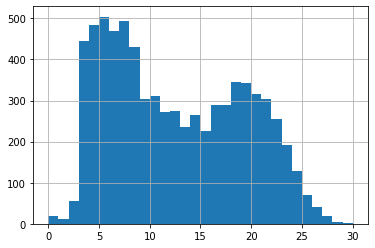

In [130]:
# Get length of all the tweets in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

### **Set the padding length**

In [146]:
max_seq_len = 56

### **Tokenize the tweets**

In [147]:
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_validation.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## **Convert integer sequences to tensors**

In [148]:
# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(Y_train.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(Y_validation.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(Y_test.tolist())

## **Create Data Loaders**

In [149]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, 
                              batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, 
                            batch_size=batch_size)

## **Freeze BERT parameters**

In [94]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True

## **Define model architecture**

In [150]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

## **Set BERT model**

In [151]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)

## **Define the optimizer**

In [152]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 2e-5)

## **Find class weights**

In [153]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight('balanced', np.unique(Y_train), Y_train)

# Convert class weights to tensor
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# Loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# Number of training epochs
epochs = 2

## **Fine-tune BERT**

### **Training the model**

In [154]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]
  
  # Iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Sppend the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds

### **Evaluating the model**

In [155]:
def evaluate():
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### **Start model training**

In [156]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    232.
  Batch   100  of    232.
  Batch   150  of    232.
  Batch   200  of    232.

Evaluating...

Training Loss: 0.493
Validation Loss: 0.473

 Epoch 2 / 2
  Batch    50  of    232.
  Batch   100  of    232.
  Batch   150  of    232.
  Batch   200  of    232.

Evaluating...

Training Loss: 0.394
Validation Loss: 0.457


### **Load saved model**

In [157]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### **Get predictions for test data**

In [158]:
with torch.no_grad():
  Y_pred = model(test_seq.to(device), test_mask.to(device))
  Y_pred = Y_pred.detach().cpu().numpy()

### **Evaluate model performance**

In [159]:
Y_pred = np.argmax(Y_pred, axis = 1)

# Calculate test accuracy
print("\nTest Accuracy: ", accuracy_score(test_y, Y_pred))
print("Test Precision: ", precision_score(test_y, Y_pred))
print("Test Recall: ", recall_score(test_y, Y_pred))
print("Test F-measure: ", f1_score(test_y, Y_pred))


Test Accuracy:  0.8216761184625079
Test Precision:  0.8667953667953668
Test Recall:  0.8609779482262704
Test F-measure:  0.8638768638768639


In [ ]:
print(classification_report(test_y, Y_pred))

              precision    recall  f1-score   support

           0       0.65      0.82      0.73       544
           1       0.89      0.77      0.83      1043

    accuracy                           0.79      1587
   macro avg       0.77      0.80      0.78      1587
weighted avg       0.81      0.79      0.79      1587



## **Get BERT Embeddings after fine-tuning**

In [160]:
total_number_of_rows, total_number_of_columns = labeled_dataset_df.shape
bert_features = []

# Select number of iterations
iterations = total_number_of_rows//2000

i = 0
j = 2000
while j != -2:
  # Select batch dataset
  bert_dataset = labeled_dataset_df.iloc[i:j]

  # Tokenize first batch
  tokenized_tweets_dataset = bert_dataset["tweet"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  # Padded tokenized batch
  max_len = 0
  for k in tokenized_tweets_dataset.values:
      if len(k) > max_len:
          max_len = len(k)
  padded_tokenize_tweets_dataset = np.array([n + [0]*(max_len-len(n)) for n in tokenized_tweets_dataset.values])

  # Add attention mask
  attention_mask_dataset = np.where(padded_tokenize_tweets_dataset != 0, 1, 0)

  # Calculate the sentence embeddings
  input_tweets_ids_dataset = torch.tensor(padded_tokenize_tweets_dataset)  
  attention_mask_dataset = torch.tensor(attention_mask_dataset)
  with torch.no_grad():
      last_hidden_states_dataset = model.bert(input_tweets_ids_dataset.to(device), 
                                              attention_mask = attention_mask_dataset.to(device))
  
  # Append Batch BERT features
  features_dataset = last_hidden_states_dataset[0][:,0,:].cpu().numpy()
  if np.array_equal(bert_features, []):
    bert_features = features_dataset
  else:
    bert_features = np.concatenate((bert_features, features_dataset), axis=0)

  # Update i and j pointers
  i = j
  if j + 2000 <= total_number_of_rows:
    j = j + 2000
  else:
    if j == total_number_of_rows:
      j = -2
    elif j < total_number_of_rows:
      j = total_number_of_rows

## **Reducing Dimensionality**

In [161]:
from sklearn.decomposition import PCA

def reduce_features_dimensionality(feature, number_of_dimensions):
    pca = PCA(number_of_dimensions)
    reduce_df = pd.DataFrame(pca.fit_transform(feature))
    return reduce_df

features = reduce_features_dimensionality(bert_features, 10)

## **Normalize calculated features using MinMaxScaler**

In [162]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize using the mean value
sc = MinMaxScaler()
normalized_df = sc.fit_transform(features)

## **Select X and Y**

In [163]:
# Select the data
def select_data(normalize_data = False):
  if normalize_data:
    return normalized_df, labeled_dataset_df.label
  return features, labeled_dataset_df.label

X, Y = select_data(normalize_data = True)

## **Handle imbalance data using SMOTE**

In [164]:
from imblearn.over_sampling import SMOTE

# Transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Select train and test data**

In [165]:
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.2)

## **Logistic Regression Model**

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Train the model
logistic_classifier = LogisticRegression(solver='lbfgs').fit(X_train,
                                                             Y_train)

# Calculate training accuracy
Y_pred = logistic_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = logistic_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8682672421544825
Training Precision:  0.8988807410266306
Training Recall:  0.831934273977496
Training F-measure:  0.8641127910212411

Test Accuracy:  0.8683926645091694
Test Precision:  0.8833592534992224
Test Recall:  0.8402366863905325
Test F-measure:  0.8612585291887794


In [167]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.87      1429
           1       0.88      0.84      0.86      1352

    accuracy                           0.87      2781
   macro avg       0.87      0.87      0.87      2781
weighted avg       0.87      0.87      0.87      2781



## **SVM Model**

In [168]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the model
svm_classifier = SVC()
svm_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = svm_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = svm_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.8749213200251776
Training Precision:  0.9091793076623882
Training Recall:  0.8349705304518664
Training F-measure:  0.8704962294013593

Test Accuracy:  0.8705501618122977
Test Precision:  0.889937106918239
Test Recall:  0.8372781065088757
Test F-measure:  0.8628048780487804


In [169]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1429
           1       0.89      0.84      0.86      1352

    accuracy                           0.87      2781
   macro avg       0.87      0.87      0.87      2781
weighted avg       0.87      0.87      0.87      2781



## **Multinomial Naive Bayes Model**

In [170]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = multinomial_naive_bayes_classifier.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.860084524772952
Training Precision:  0.921584984358707
Training Recall:  0.7892480800142883
Training F-measure:  0.8502982489898018

Test Accuracy:  0.8709097446961525
Test Precision:  0.9168765743073047
Test Recall:  0.8076923076923077
Test F-measure:  0.8588281557215887


In [171]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1429
           1       0.92      0.81      0.86      1352

    accuracy                           0.87      2781
   macro avg       0.88      0.87      0.87      2781
weighted avg       0.88      0.87      0.87      2781



## **Random Forest Model**

#### **Set the grid parameters to be optimized for Random Forest**

In [172]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
              }

# Use this combination of parameters for RandomizedSearchCV
model_params = {
    'n_estimators': randint(4,200),
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    'min_samples_split': uniform(0.01, 0.199)
}

#### **Find the parameters that optimize the Random Forest Model**

In [173]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation
random_forest_random = RandomizedSearchCV(estimator = random_forest, 
                                          param_distributions = model_params, 
                                          n_iter = 100, cv = 3, verbose=2, 
                                          random_state=42, 
                                          n_jobs = -1)

# Fit the random search model
random_forest_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### **Train Random Forest Classifier model after performing Cross-Validation**

In [174]:
# Select best Random Forest Model
hypertuned_random_forest_model = random_forest_random.best_estimator_

# Calculate training accuracy
Y_pred = hypertuned_random_forest_model.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = hypertuned_random_forest_model.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.87896771873033
Training Precision:  0.904354440007606
Training Recall:  0.8494373995356314
Training F-measure:  0.8760361024129675

Test Accuracy:  0.8723480762315714
Test Precision:  0.881992337164751
Test Recall:  0.8513313609467456
Test F-measure:  0.8663906661648476


## **Stacking Model**

In [175]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Define the base learners models
base_learners = list()
base_learners.append(('bayes', MultinomialNB()))
base_learners.append(('rf', hypertuned_random_forest_model))
base_learners.append(('svm', SVC()))

# Define the meta learner model
meta_learner = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators = base_learners, 
                                       final_estimator = meta_learner, 
                                       cv = 10)

# Train the model
stacking_ensemble.fit(X_train, Y_train)

# Calculate training accuracy
Y_pred = stacking_ensemble.predict(X_train)
print("Training Accuracy: ", accuracy_score(Y_train, Y_pred))
print("Training Precision: ", precision_score(Y_train, Y_pred))
print("Training Recall: ", recall_score(Y_train, Y_pred))
print("Training F-measure: ", f1_score(Y_train, Y_pred))

# Calculate test accuracy
Y_pred = stacking_ensemble.predict(X_test)
print("\nTest Accuracy: ", accuracy_score(Y_test, Y_pred))
print("Test Precision: ", precision_score(Y_test, Y_pred))
print("Test Recall: ", recall_score(Y_test, Y_pred))
print("Test F-measure: ", f1_score(Y_test, Y_pred))

Training Accuracy:  0.87896771873033
Training Precision:  0.9031279620853081
Training Recall:  0.8508662261118057
Training F-measure:  0.8762185028508368

Test Accuracy:  0.8727076591154261
Test Precision:  0.8814984709480123
Test Recall:  0.852810650887574
Test F-measure:  0.8669172932330829
